In [1]:
dataset <- "TAA"
merging_datasets <- c(dataset, "ISAC")
state <- "Trentino-Alto Adige"
match_dist <- 15000
new_dataset <- "TAA2"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
nat_meta <- query_checkpoint_meta("ISAC", "qc1", conns$data) |>
    mutate(user_code = str_to_upper(user_code) |> str_squish()) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Veneto", "Lombardia")))
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    mutate(user_code = str_to_upper(user_code) |> str_squish()) |>
    collect()

metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "trentino", "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "integrazioni_regionali", "trentino", "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/integrazioni_regionali/trentino/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", "trentino", "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, c("TAA", "ISAC"), desc(dataset), desc(sensor_last))
ignore_corrections <- make_exclusion_table(tagged_analysis, tibble(network_x = "ISAC", network_y = c("meteotrentino", "bolzano_xlsx", "bolzano_api")))
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 1L, 0.5, ignore_corrections)


In [7]:
i <- incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_y" = "key")) |>
    arrange(desc(abs(k0)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name.x,dataset.x,sensor_key.x,name.y,dataset.y,sensor_key.y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
326,1.1713626,-0.699348002,1.637047e-01,0.138405340,163,605,245,1,0,Val D'Ambiez,TAA,269,VAL_D_AMBIEZ,ISAC,3647
217,-1.0644443,0.896223412,-1.532908e-01,-0.142104465,109,511,185,-1,0,Lago Di Calaita,TAA,162,LAGO_DI_CALAITA,ISAC,3582
210,0.9710526,0.000000000,0.000000e+00,0.000000000,105,502,181,1,0,Ghiacciaio Del Careser,TAA,152,GHIACCIAIO_DEL_CARESER,ISAC,3576
193,-0.8898910,0.765321089,-1.328132e-01,-0.131575839,97,491,173,-1,0,Daone (Malga Bissina),TAA,139,DAONE_MALGA_BISSINA,ISAC,3566
282,0.8562092,0.000000000,0.000000e+00,0.000000000,141,569,220,1,0,Ragoli (Rifugio Alimonta),TAA,225,RAGOLI_RIFUGIO_ALIMONTA,ISAC,3619
11,-0.8347278,0.398617297,1.428706e-01,0.162785304,6,10,11,-1,0,BRESSANONE,ISAC,425,BRESSANONE_MTX,ISAC,426
240,0.8229591,-0.184742126,1.742323e-01,-0.019911396,120,532,198,1,0,Monte Groste' (Rifugio Graffer),TAA,185,MONTE_GROST_RIFUGIO_GRAFFER,ISAC,3596
17,0.8181818,0.000000000,0.000000e+00,0.000000000,9,521,15,-1,0,Mazzin (Campestrin),TAA,173,CAMPESTRIN,ISAC,511
204,0.7553686,-0.377644861,-2.106329e-02,0.009405405,102,497,178,1,0,Folgarida Alta,TAA,146,FOLGARIDA_ALTA,ISAC,3571


In [9]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, 10)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations)
# rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2166241,115.7,5032681,268.8,NA,5032681,268.8
Vcells,57113454,435.8,158813265,1211.7,16384,198457053,1514.2


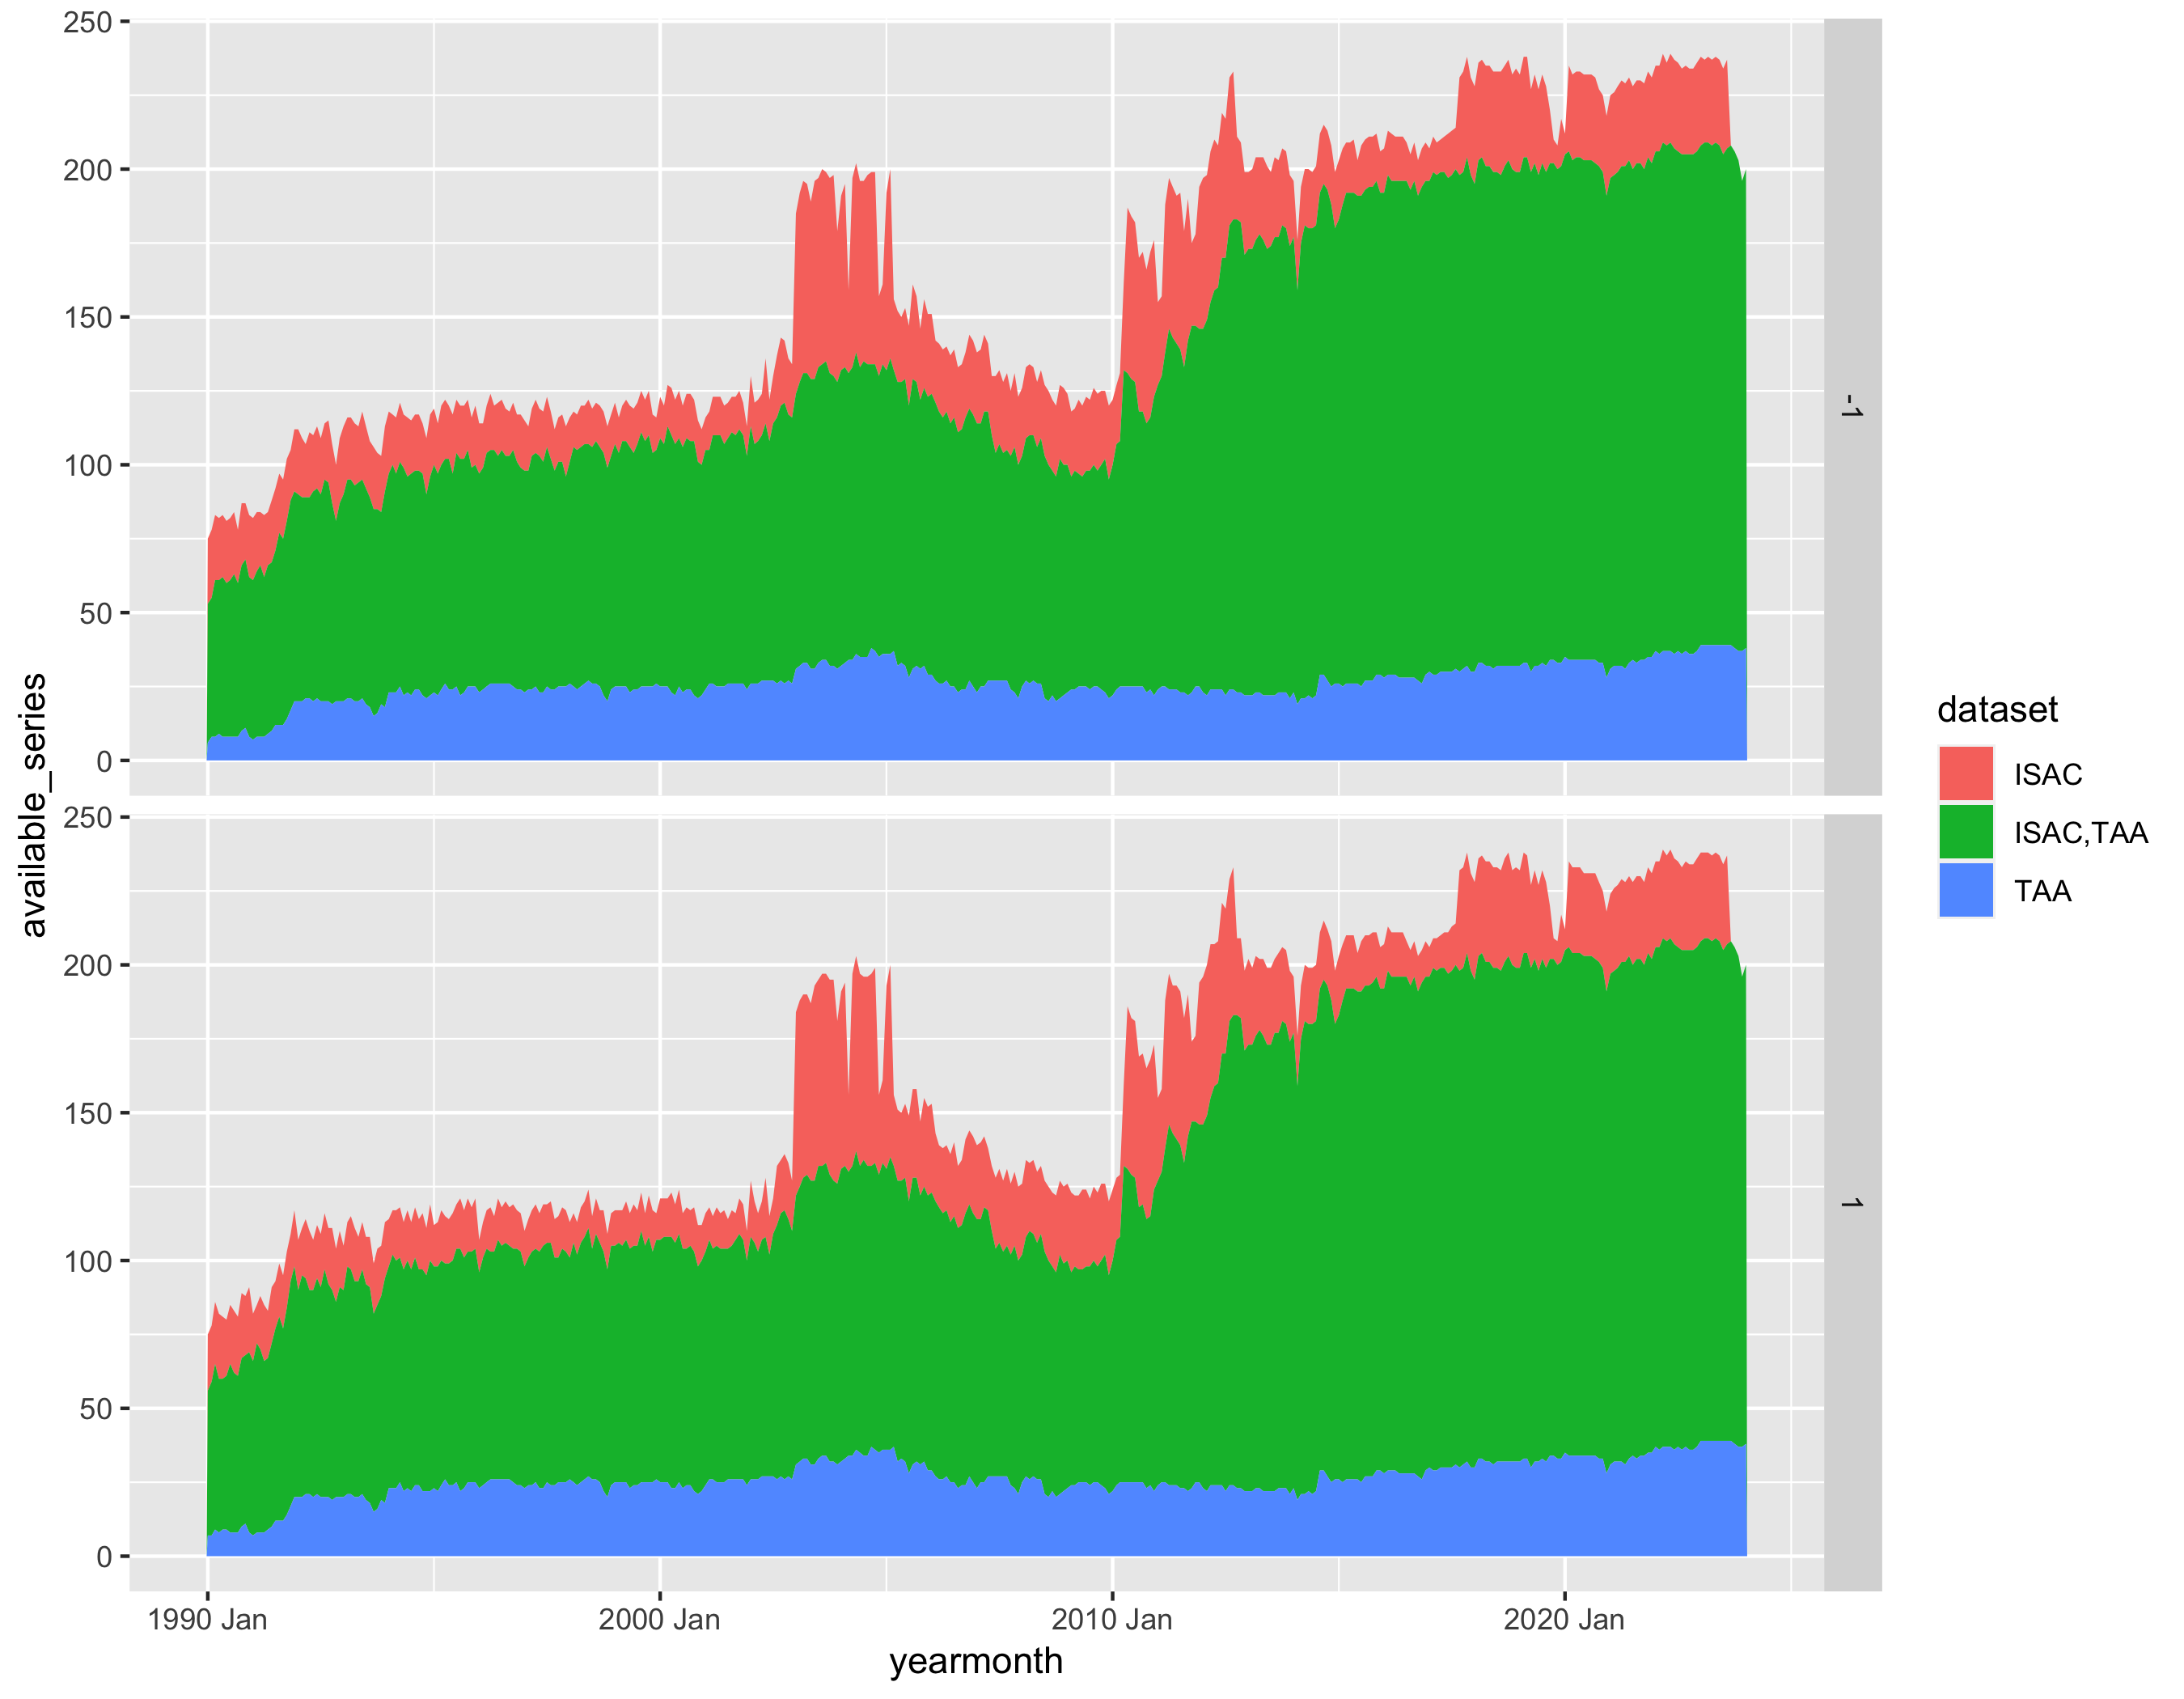

In [10]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


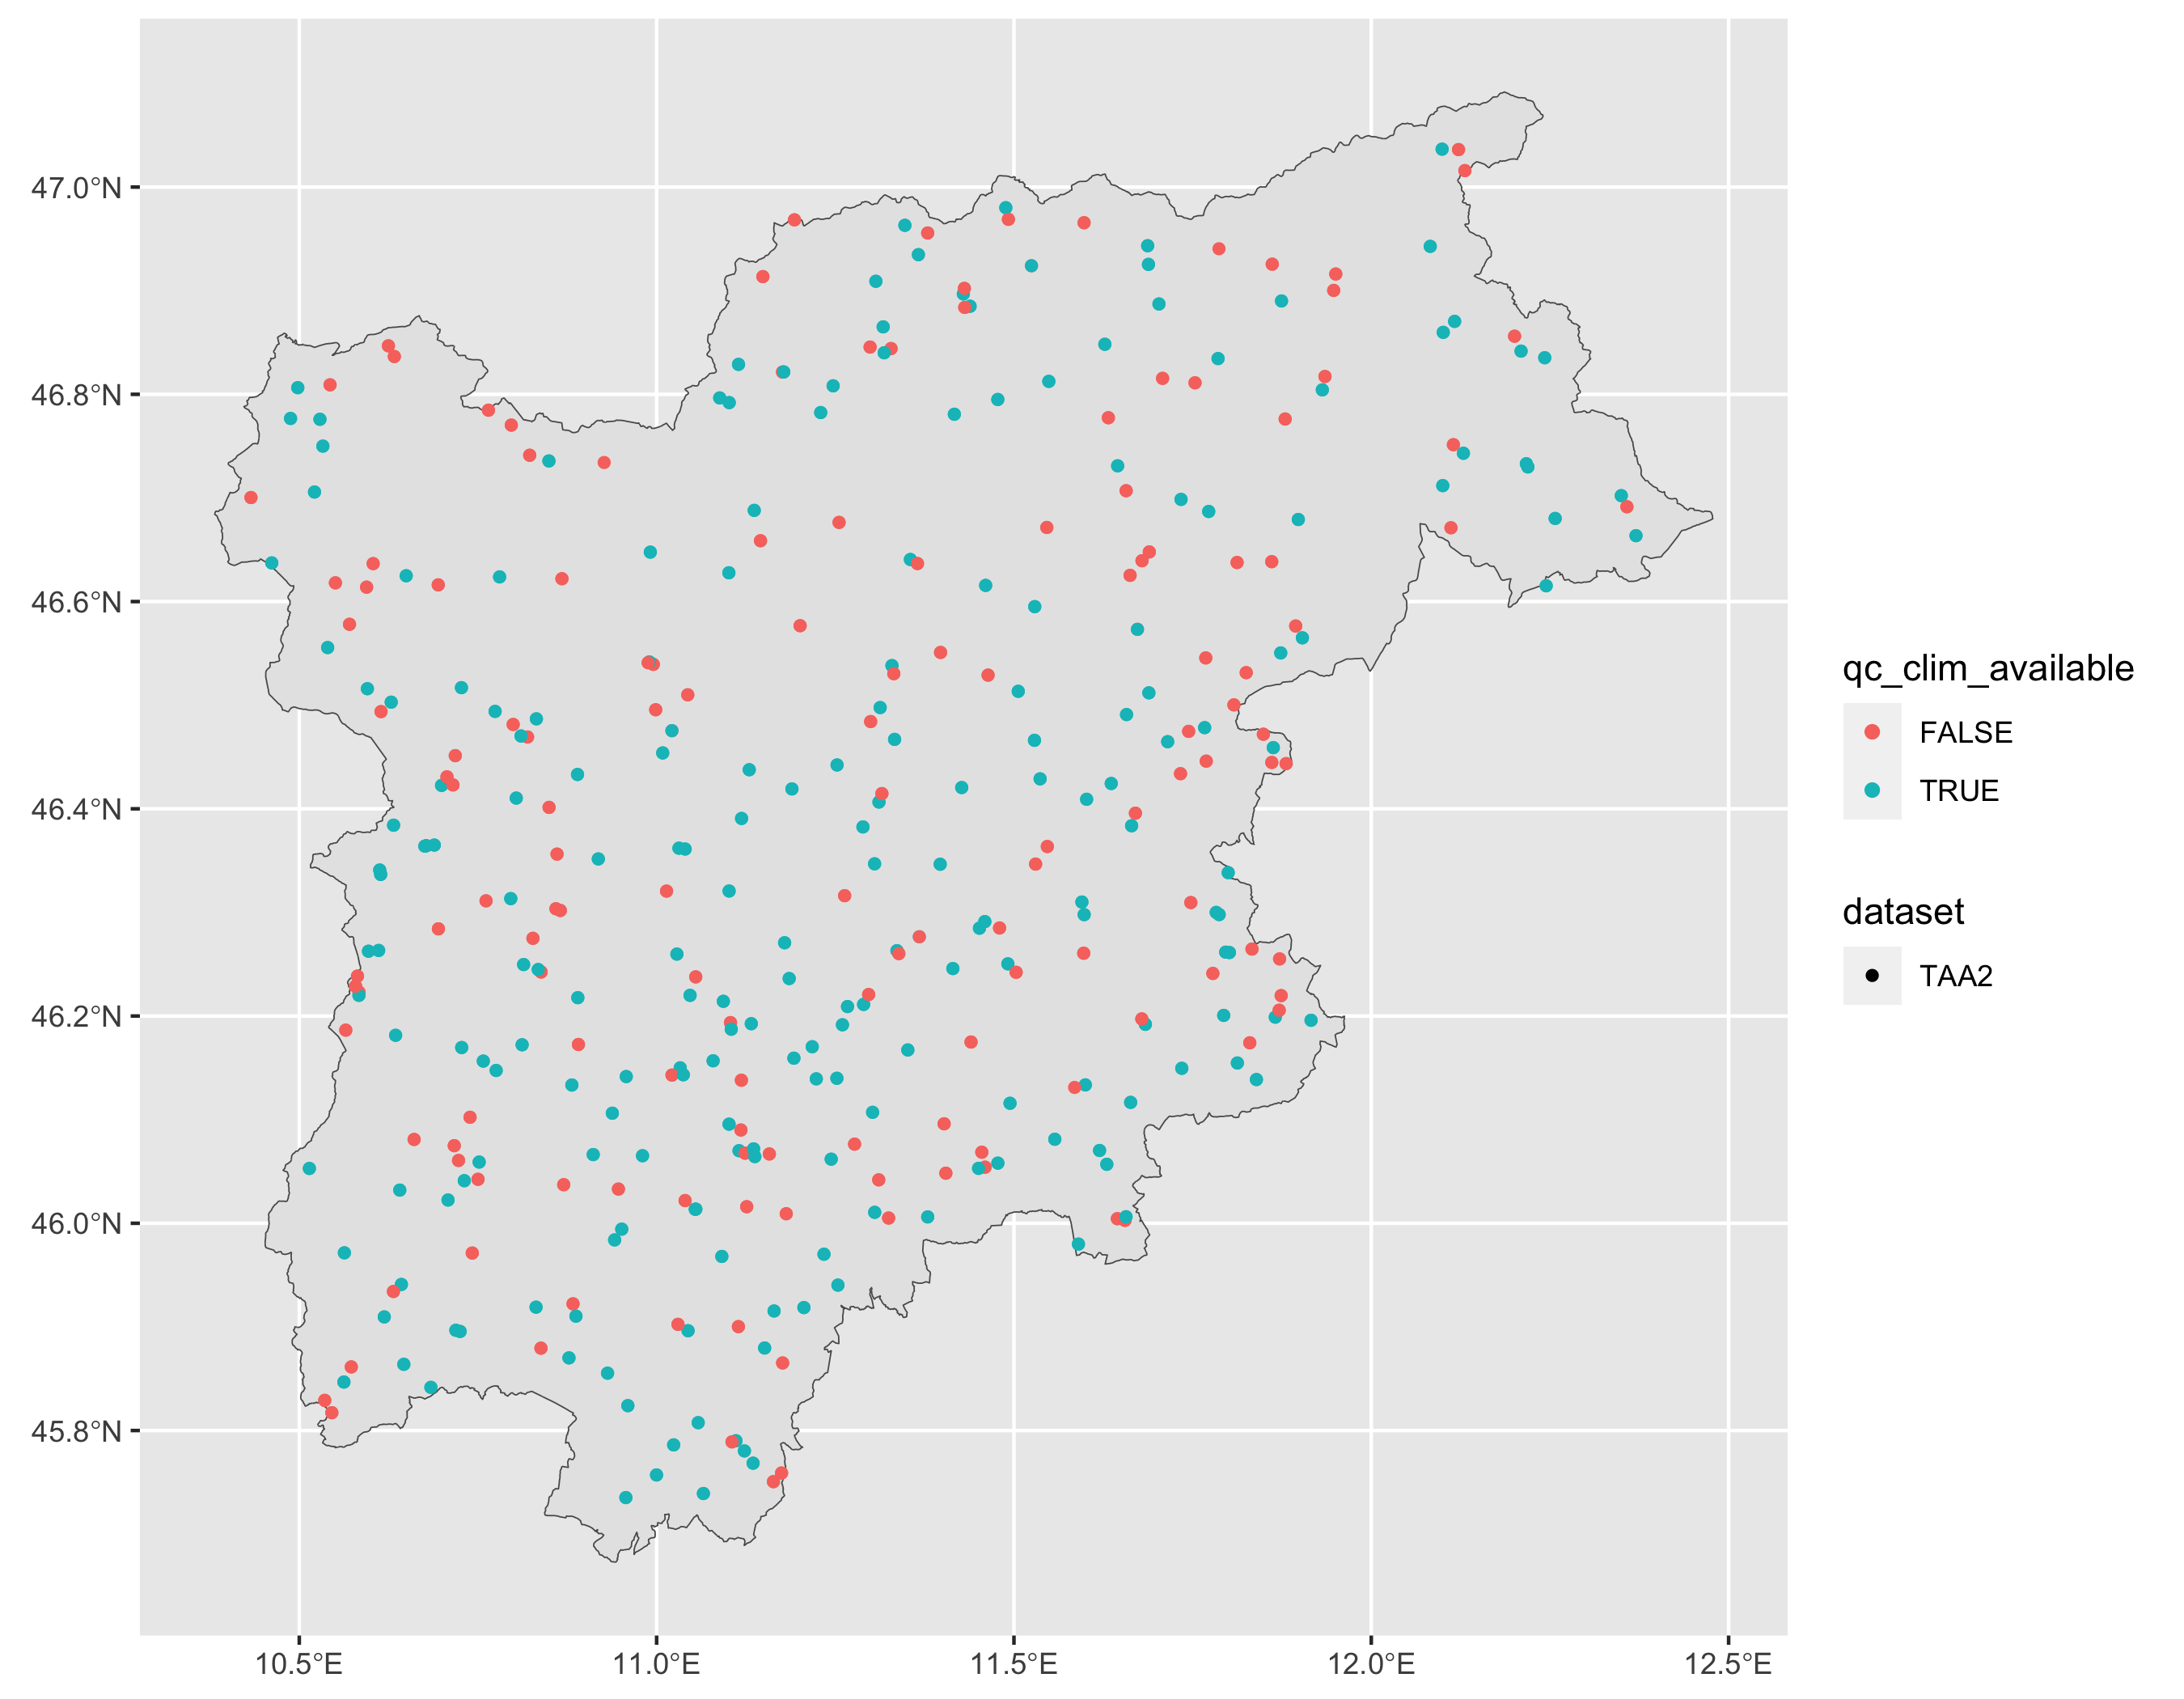

In [11]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 10L)
pd$plot


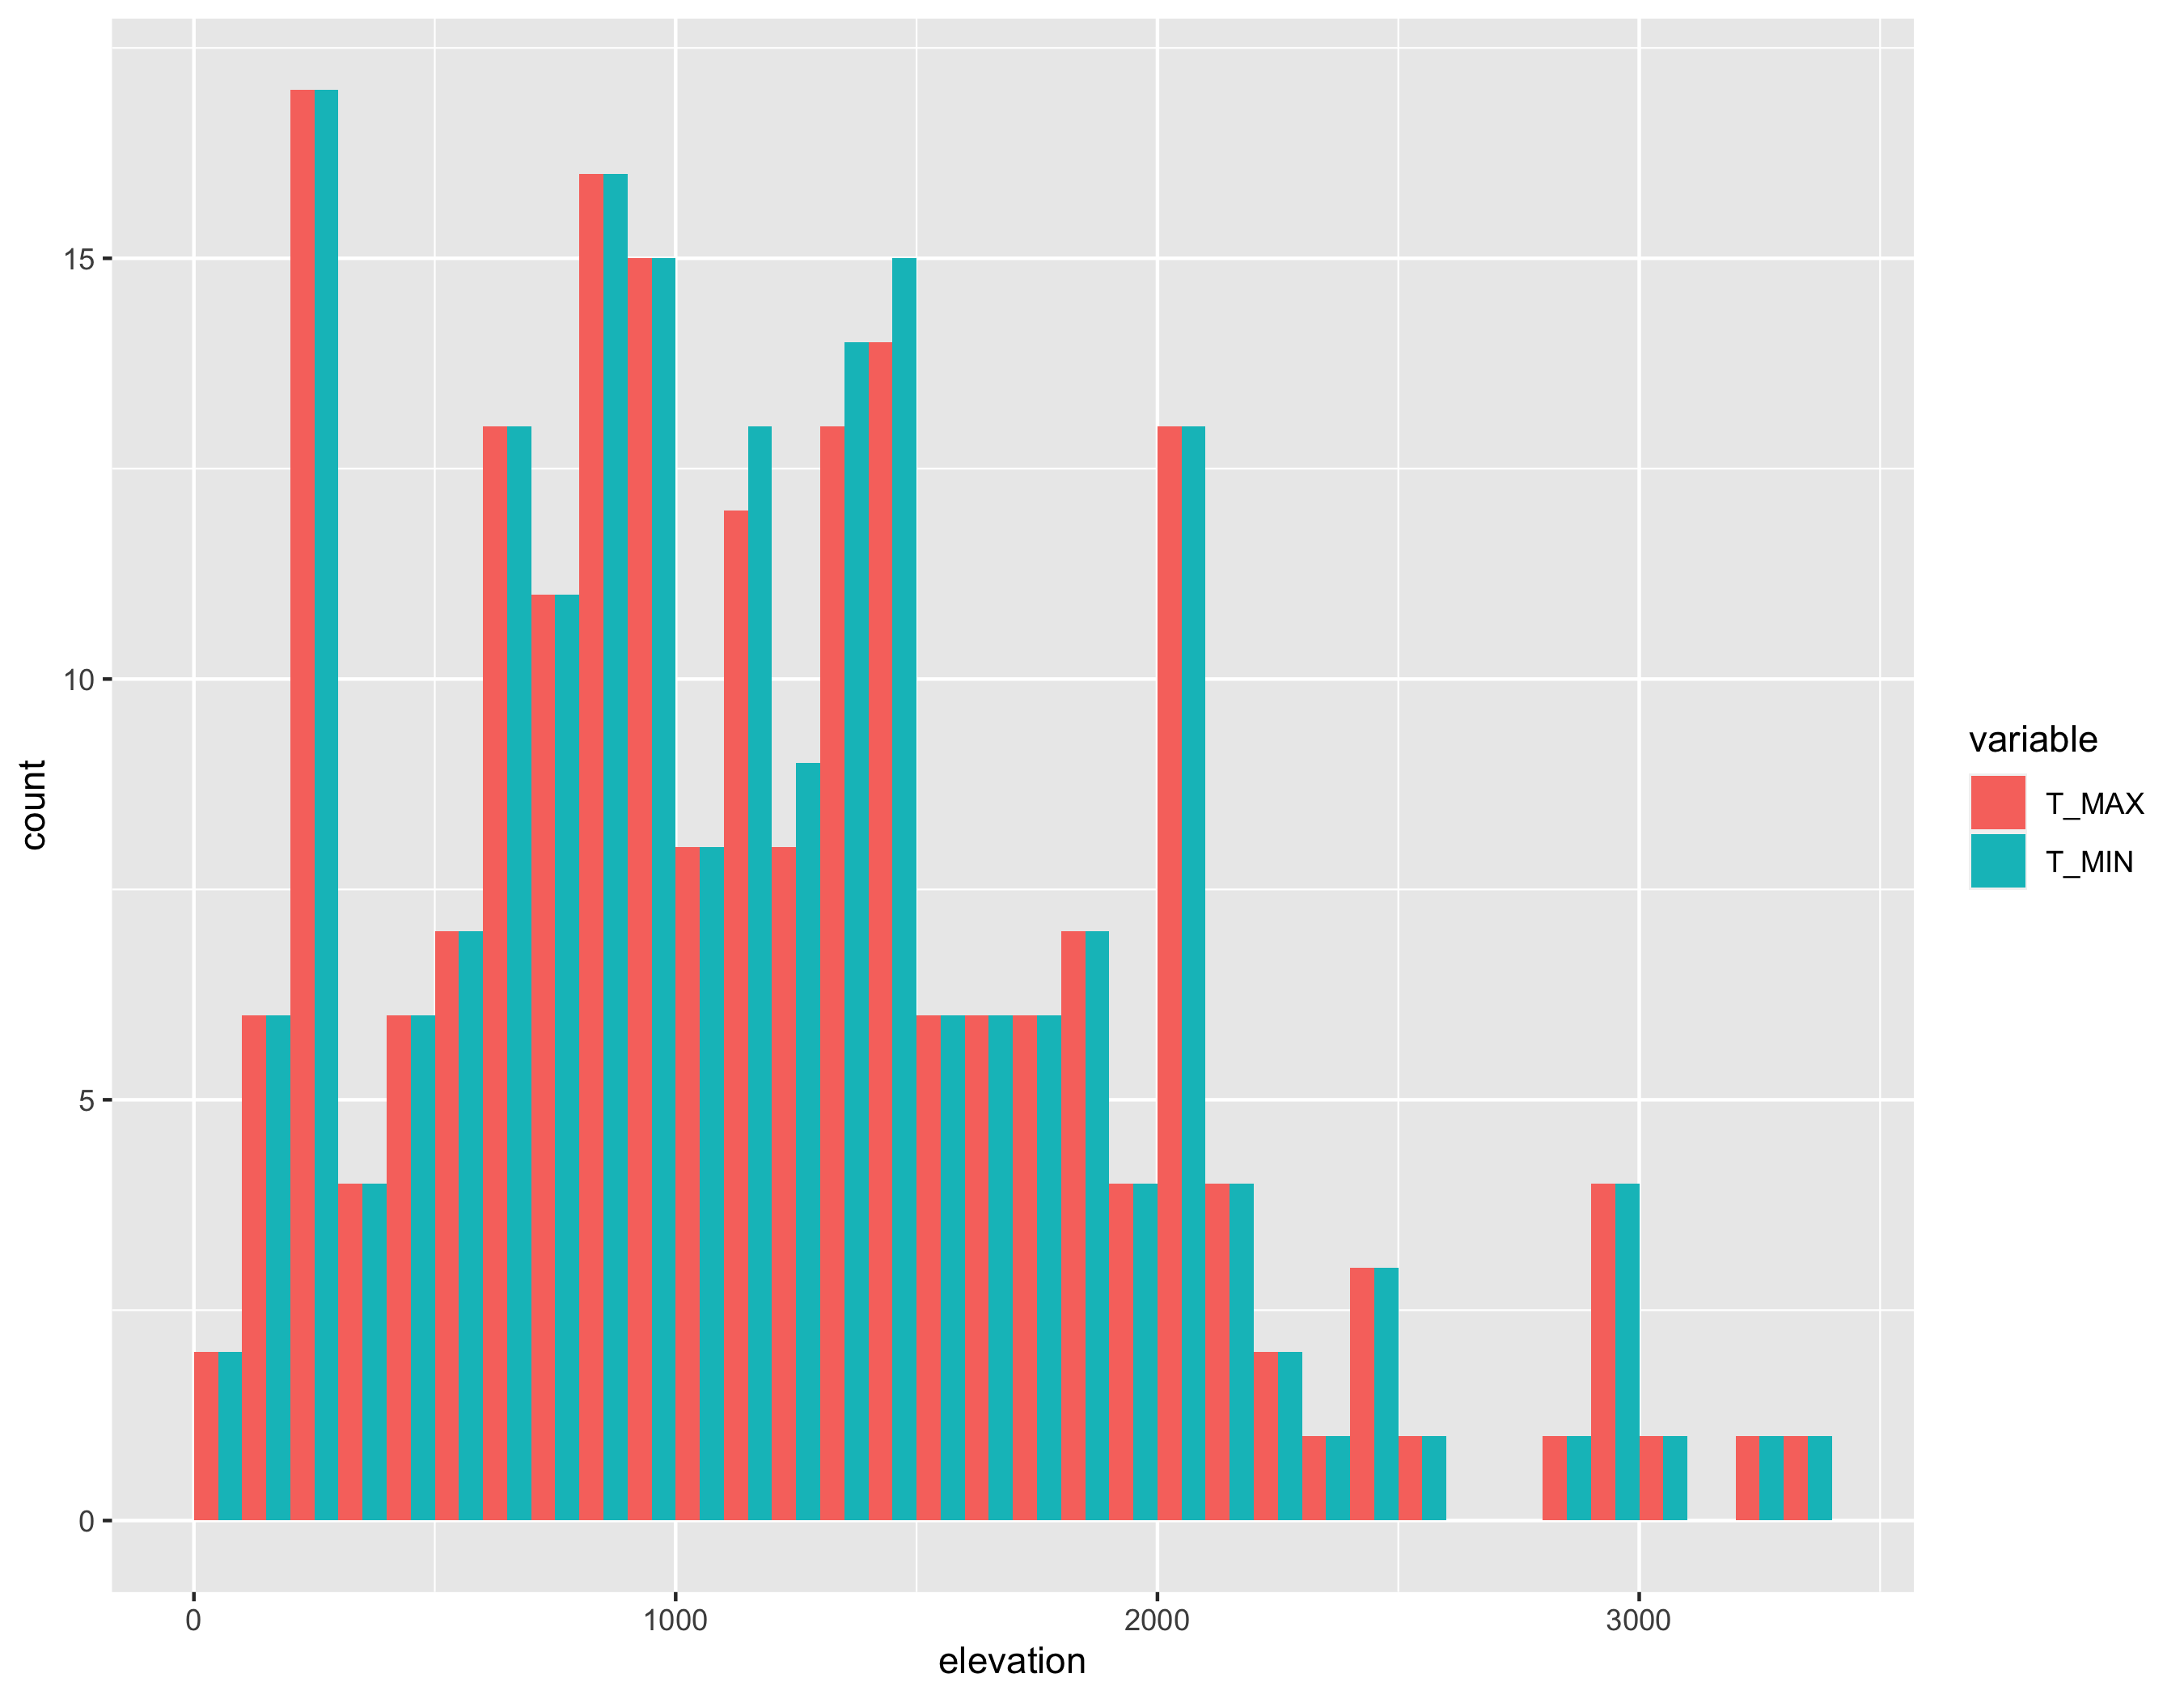

In [45]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [10]:
db$meta |>
    collect() |>
    rowwise() |>
    mutate(from_datasets = str_flatten_comma(from_datasets), from_sensor_keys = str_flatten_comma(from_sensor_keys)) |>
    st_md_to_sf() |>
    write_sf("taa.kml")
